<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li></ul></li><li><span><a href="#Predicción-de-Ozono-para-el-Valle-de-México" data-toc-modified-id="Predicción-de-Ozono-para-el-Valle-de-México-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predicción de Ozono para el Valle de México</a></span><ul class="toc-item"><li><span><a href="#Para-el-Valle-de-México-por-hora" data-toc-modified-id="Para-el-Valle-de-México-por-hora-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Para el Valle de México por hora</a></span></li></ul></li><li><span><a href="#Predicción-de-Ozono-para-Guadalajara" data-toc-modified-id="Predicción-de-Ozono-para-Guadalajara-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Predicción de Ozono para Guadalajara</a></span><ul class="toc-item"><li><span><a href="#Para-GDL-por-hora" data-toc-modified-id="Para-GDL-por-hora-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Para GDL por hora</a></span></li></ul></li><li><span><a href="#Comparar-componentes-temporales" data-toc-modified-id="Comparar-componentes-temporales-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparar componentes temporales</a></span></li><li><span><a href="#Errores" data-toc-modified-id="Errores-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Errores</a></span></li></ul></div>

In [35]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import json
from pathlib import Path
import altair as alt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from fbprophet import Prophet

pd.options.mode.chained_assignment = None

%matplotlib inline

Para correr este notebook se necesitan los datos de estaciones y mediciones de SINAICA. Se hace en [este notebook](https://github.com/opintel/calidad-del-aire/blob/master/notebooks/1_obtener_datos_calidad_del_aire.ipynb)

# Init data

## Estaciones

In [2]:
estaciones = pd.read_csv('/data_estaciones_sinaica.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 8)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
0,5b8850e3e2705c1932e82ff8,21.873311,-102.320803,31,CBTIS,CBT,30,2018-08-30 20:17:39.218
1,5b8850e3e2705c1932e82ff9,21.846392,-102.288431,32,Secretaría de Medio Ambiente,SMA,30,2018-08-30 20:17:39.218
2,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218
3,5b8850e3e2705c1932e82ffb,31.859917,-116.593722,36,Secundaria,SPABC20,31,2018-08-30 20:17:39.218
4,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218


## Data Mediciones

In [3]:
mediciones = pd.read_csv('/data_mediciones_todas_estaciones.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [4]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(123, 3)


,city,state,estacionesid
0,Durango,Durango,58
6543,Durango,Durango,59
33554,Durango,Durango,60
65683,Gómez Palacio,Durango,65
80484,Celaya,Guanajuato,68


In [5]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

In [6]:
estaciones_ciudad[estaciones_ciudad.city=='Valle de México'].merge(estaciones)

,city,state,estacionesid,_id,lat,long,nombre,codigo,redesid,date-insert
0,Valle de México,Ciudad de México,242,5b8850e3e2705c1932e8306b,19.272222,-99.207778,Ajusco Medio,AJM,119,2018-08-30 20:17:39.225
1,Valle de México,Ciudad de México,243,5b8850e3e2705c1932e8306c,19.577222,-99.254167,Atizapán,ATI,119,2018-08-30 20:17:39.225
2,Valle de México,Ciudad de México,244,5b8850e3e2705c1932e8306d,19.468611,-99.170000,Camarones,CAM,119,2018-08-30 20:17:39.225
3,Valle de México,Ciudad de México,245,5b8850e3e2705c1932e8306e,19.326389,-99.176111,Centro de Ciencias de la Atmósfera,CCA,119,2018-08-30 20:17:39.225
4,Valle de México,Ciudad de México,248,5b8850e3e2705c1932e83071,19.365556,-99.291944,Cuajimalpa,CUA,119,2018-08-30 20:17:39.225
5,Valle de México,Ciudad de México,250,5b8850e3e2705c1932e83073,19.482500,-99.243611,FES Acatlán,FAC,119,2018-08-30 20:17:39.225
6,Valle de México,Ciudad de México,251,5b8850e3e2705c1932e83074,19.411667,-99.152222,Hospital General de México,HGM,119,2018-08-30 20:17:39.225
7,Valle de México,Ciudad de México,253,5b8850e3e2705c1932e83076,19.535000,-99.117778,La Presa,LPR,119,2018-08-30 20:17:39.225
8,Valle de México,Ciudad de México,256,5b8850e3e2705c1932e83078,19.424722,-99.119722,Merced,MER,119,2018-08-30 20:17:39.225
9,Valle de México,Ciudad de México,257,5b8850e3e2705c1932e83079,19.460417,-98.902861,Montecillo,MON,119,2018-08-30 20:17:39.225


# Predicción de Ozono para el Valle de México

In [7]:
ciudad = mediciones[(mediciones.city.isin(['Valle de México']))]
ciudad['fecha_hora']  = pd.to_datetime(ciudad.fecha + ' ' +
                                            ciudad.hora.astype(str) +':00:00')

ciudad['fecha'] = pd.to_datetime(ciudad.fecha)

ciudad['dia_semana'] = ciudad.fecha.dt.weekday_name

O3_valleMex = ciudad[(ciudad.parametro.isin(['O3']))]

O3_valleMex = O3_valleMex.sort_values('fecha_hora')
print(O3_valleMex.shape)
O3_valleMex.head()

(152281, 10)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora,dia_semana
1891057,Valle de México,240,2018-01-01,0,O3,Ciudad de México,1,0.011,2018-01-01,Monday
2718294,Valle de México,301,2018-01-01,0,O3,Ciudad de México,1,0.038,2018-01-01,Monday
2052820,Valle de México,249,2018-01-01,0,O3,Ciudad de México,1,0.018,2018-01-01,Monday
2078440,Valle de México,250,2018-01-01,0,O3,Ciudad de México,1,0.026,2018-01-01,Monday
2104364,Valle de México,251,2018-01-01,0,O3,Ciudad de México,1,0.015,2018-01-01,Monday


## Para el Valle de México por hora

In [8]:
ts_estacion = O3_valleMex.groupby('fecha_hora').valororig.mean().reset_index()
ts_estacion['fecha_hora'] = pd.to_datetime(ts_estacion.fecha_hora)

ntest = 12

ts_test = ts_estacion[-ntest::][['fecha_hora', 'valororig']]
ts_test.columns = ['ds', 'y']

ts_estacion = ts_estacion[['fecha_hora', 'valororig']][0:-ntest]
ts_estacion.columns = ['ds', 'y']

# Vamos a llenar los valores donde no tenemos mediciones con la media por dia de la semana y hora
ts_estacion = ts_estacion.set_index('ds').resample('H').mean() # mediciones consecutivas por hora
ts_estacion['weekday'] = ts_estacion.index.weekday_name
ts_estacion['hora'] = ts_estacion.index.hour
# Con estos 
fillnas = ts_estacion.groupby(['weekday', 'hora']).transform('mean').y
ts_estacion['y'] = np.where(ts_estacion.y.isnull(), fillnas, ts_estacion.y)

ts_estacion = ts_estacion[['y']].reset_index()

print(ts_estacion.shape)
ts_estacion.head()

(5908, 2)


,ds,y
0,2018-01-01 00:00:00,0.016519
1,2018-01-01 01:00:00,0.019481
2,2018-01-01 02:00:00,0.020308
3,2018-01-01 03:00:00,0.018704
4,2018-01-01 04:00:00,0.017462


/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


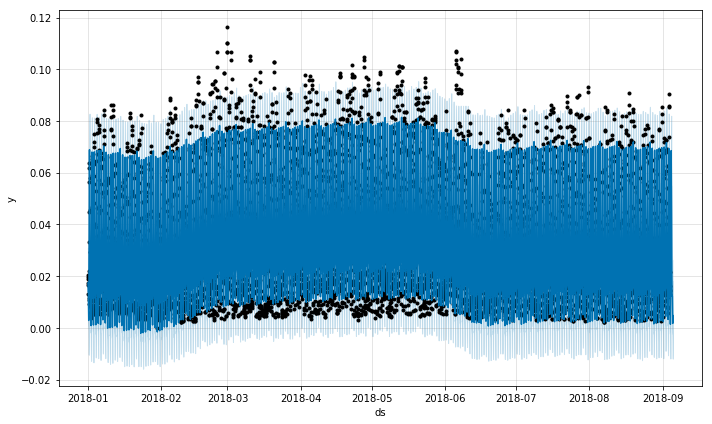

In [9]:
# Se hacen las predicciones
model_cdmx = Prophet(yearly_seasonality=False).fit(ts_estacion)
future_cdmx = model_cdmx.make_future_dataframe(periods=30, freq='H')
fcst_cdmx = model_cdmx.predict(future_cdmx)
fig = model_cdmx.plot(fcst_cdmx)

In [10]:
# Obtenemos errores usando valor absoluto relativo
errors_cdmx = fcst_cdmx.merge(ts_test, on='ds')
errors_cdmx['RAE'] = abs(errors_cdmx.y-errors_cdmx.yhat)/errors_cdmx.y
print(errors_cdmx.shape)
errors_cdmx

(12, 21)


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,y,RAE
0,2018-09-04 04:00:00,0.029471,0.029471,0.029471,-0.001424,0.024963,-0.016483,-0.016483,-0.016483,-0.017580,...,-0.017580,-0.017580,-0.017580,-0.017580,-0.001097,-0.001097,-0.001097,0.011891,0.013310,0.106649
1,2018-09-04 05:00:00,0.029470,0.029470,0.029470,-0.004105,0.024413,-0.018248,-0.018248,-0.018248,-0.019368,...,-0.019368,-0.019368,-0.019368,-0.019368,-0.001119,-0.001119,-0.001119,0.010102,0.011310,0.106801
2,2018-09-04 06:00:00,0.029469,0.029469,0.029469,-0.006840,0.020378,-0.021753,-0.021753,-0.021753,-0.022888,...,-0.022888,-0.022888,-0.022888,-0.022888,-0.001136,-0.001136,-0.001136,0.006581,0.007250,0.092289
3,2018-09-04 07:00:00,0.029468,0.029468,0.029468,-0.011615,0.016060,-0.025493,-0.025493,-0.025493,-0.026639,...,-0.026639,-0.026639,-0.026639,-0.026639,-0.001146,-0.001146,-0.001146,0.002830,0.003828,0.260681
4,2018-09-04 08:00:00,0.029468,0.029468,0.029468,-0.011888,0.014430,-0.026940,-0.026940,-0.026940,-0.028090,...,-0.028090,-0.028090,-0.028090,-0.028090,-0.001150,-0.001150,-0.001150,0.001378,0.003067,0.550803
5,2018-09-04 09:00:00,0.029467,0.029467,0.029467,-0.008921,0.018009,-0.023937,-0.023937,-0.023937,-0.025086,...,-0.025086,-0.025086,-0.025086,-0.025086,-0.001149,-0.001149,-0.001149,0.004381,0.004645,0.056958
6,2018-09-04 10:00:00,0.029466,0.029466,0.029466,-0.001156,0.026154,-0.015857,-0.015857,-0.015857,-0.017000,...,-0.017000,-0.017000,-0.017000,-0.017000,-0.001144,-0.001144,-0.001144,0.012466,0.011387,0.094731
7,2018-09-04 11:00:00,0.029465,0.029465,0.029465,0.011156,0.037701,-0.003805,-0.003805,-0.003805,-0.004939,...,-0.004939,-0.004939,-0.004939,-0.004939,-0.001134,-0.001134,-0.001134,0.024526,0.019759,0.241299
8,2018-09-04 12:00:00,0.029464,0.029464,0.029464,0.024842,0.051696,0.010031,0.010031,0.010031,0.008911,...,0.008911,0.008911,0.008911,0.008911,-0.001120,-0.001120,-0.001120,0.038375,0.034690,0.106240
9,2018-09-04 13:00:00,0.029463,0.029463,0.029463,0.037836,0.065420,0.023232,0.023232,0.023232,0.022129,...,0.022129,0.022129,0.022129,0.022129,-0.001104,-0.001104,-0.001104,0.051592,0.053407,0.033990


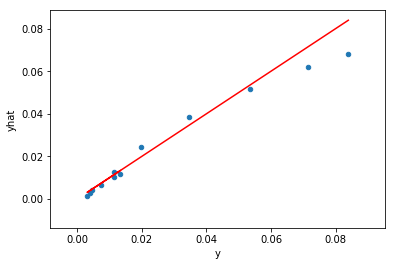

In [11]:
errors_cdmx.plot.scatter('y', 'yhat')
plt.plot(errors_cdmx.y, errors_cdmx.y, color='red')

count    12.000000
mean      0.164450
std       0.139719
min       0.033990
25%       0.094121
50%       0.106725
75%       0.202569
max       0.550803
Name: RAE, dtype: float64

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


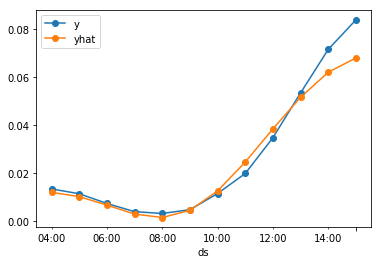

In [12]:
# Los errores son porcentajes
display(errors_cdmx.RAE.describe())
errors_cdmx.plot(x='ds', y=['y', 'yhat'], style='-o')

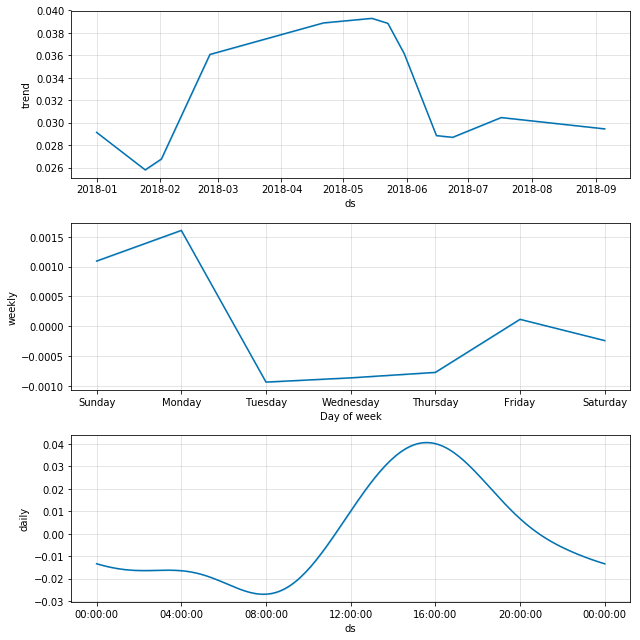

In [13]:
# Graficar componentes
fig = model_cdmx.plot_components(fcst_cdmx)

# Predicción de Ozono para Guadalajara

In [14]:
ciudad = mediciones[(mediciones.city.isin(['Guadalajara']))]
ciudad['fecha_hora']  = pd.to_datetime(ciudad.fecha + ' ' +
                                            ciudad.hora.astype(str) +':00:00')

ciudad['fecha'] = pd.to_datetime(ciudad.fecha)

ciudad['dia_semana'] = ciudad.fecha.dt.weekday_name

O3_gdl = ciudad[(ciudad.parametro.isin(['O3']))]

O3_gdl = O3_gdl.sort_values('fecha_hora')
print(O3_gdl.shape)
O3_gdl.head()

(50232, 10)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora,dia_semana
840905,Guadalajara,104,2018-01-01,0,O3,Jalisco,1,0.017321,2018-01-01,Monday
864430,Guadalajara,105,2018-01-01,0,O3,Jalisco,1,0.024202,2018-01-01,Monday
918653,Guadalajara,107,2018-01-01,0,O3,Jalisco,1,0.005754,2018-01-01,Monday
774286,Guadalajara,102,2018-01-01,0,O3,Jalisco,1,0.009149,2018-01-01,Monday
984343,Guadalajara,109,2018-01-01,0,O3,Jalisco,1,0.008100,2018-01-01,Monday


## Para GDL por hora

In [15]:
ts_estacion = O3_gdl.groupby('fecha_hora').valororig.mean().reset_index()
ts_estacion['fecha_hora'] = pd.to_datetime(ts_estacion.fecha_hora)

ntest = 12

ts_test = ts_estacion[-ntest::][['fecha_hora', 'valororig']]
ts_test.columns = ['ds', 'y']

ts_estacion = ts_estacion[['fecha_hora', 'valororig']][0:-ntest]
ts_estacion.columns = ['ds', 'y']

# Vamos a llenar los valores donde no tenemos mediciones con la media por dia de la semana y hora
ts_estacion = ts_estacion.set_index('ds').resample('H').mean() # mediciones consecutivas por hora
ts_estacion['weekday'] = ts_estacion.index.weekday_name
ts_estacion['hora'] = ts_estacion.index.hour
# Con estos 
fillnas = ts_estacion.groupby(['weekday', 'hora']).transform('mean').y
ts_estacion['y'] = np.where(ts_estacion.y.isnull(), fillnas, ts_estacion.y)

ts_estacion = ts_estacion[['y']].reset_index()

print(ts_estacion.shape)
ts_estacion.head()

(5907, 2)


,ds,y
0,2018-01-01 00:00:00,0.017213
1,2018-01-01 01:00:00,0.013317
2,2018-01-01 02:00:00,0.009076
3,2018-01-01 03:00:00,0.004476
4,2018-01-01 04:00:00,0.005072


/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


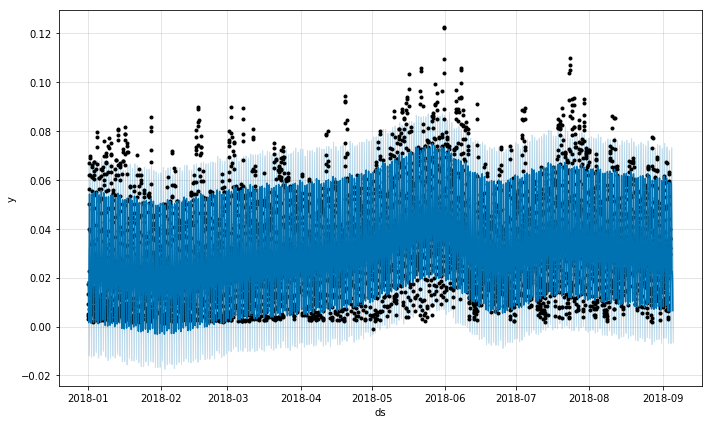

In [16]:
# Predicciones
model_gdl = Prophet(yearly_seasonality=False).fit(ts_estacion)
future_gdl = model_gdl.make_future_dataframe(periods=30, freq='H')
fcst_gdl = model_gdl.predict(future_gdl)
fig = model_gdl.plot(fcst_gdl)

In [17]:
# Errores
errors_gdl = fcst_gdl.merge(ts_test, on='ds')
errors_gdl['RAE'] = abs(errors_gdl.y-errors_gdl.yhat)/errors_gdl.y
print(errors_gdl.shape)
errors_gdl

(12, 21)


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,y,RAE
0,2018-09-04 03:00:00,0.031341,0.031341,0.031341,0.007608,0.033953,-0.009458,-0.009458,-0.009458,-0.010367,...,-0.010367,-0.010367,-0.010367,-0.010367,-0.000909,-0.000909,-0.000909,0.020974,0.028992,0.276540
1,2018-09-04 04:00:00,0.031336,0.031336,0.031336,0.006599,0.032889,-0.010624,-0.010624,-0.010624,-0.011520,...,-0.011520,-0.011520,-0.011520,-0.011520,-0.000896,-0.000896,-0.000896,0.019816,0.027573,0.281328
2,2018-09-04 05:00:00,0.031330,0.031330,0.031330,0.004173,0.030736,-0.013065,-0.013065,-0.013065,-0.013946,...,-0.013946,-0.013946,-0.013946,-0.013946,-0.000882,-0.000882,-0.000882,0.017384,0.022275,0.219594
3,2018-09-04 06:00:00,0.031325,0.031325,0.031325,-0.000305,0.025807,-0.017221,-0.017221,-0.017221,-0.018089,...,-0.018089,-0.018089,-0.018089,-0.018089,-0.000868,-0.000868,-0.000868,0.013236,0.016581,0.201719
4,2018-09-04 07:00:00,0.031319,0.031319,0.031319,-0.004568,0.021403,-0.021913,-0.021913,-0.021913,-0.022767,...,-0.022767,-0.022767,-0.022767,-0.022767,-0.000854,-0.000854,-0.000854,0.008552,0.009904,0.136452
5,2018-09-04 08:00:00,0.031314,0.031314,0.031314,-0.006767,0.019071,-0.024342,-0.024342,-0.024342,-0.025183,...,-0.025183,-0.025183,-0.025183,-0.025183,-0.000841,-0.000841,-0.000841,0.006131,0.008595,0.286705
6,2018-09-04 09:00:00,0.031308,0.031308,0.031308,-0.004496,0.022108,-0.021738,-0.021738,-0.021738,-0.022566,...,-0.022566,-0.022566,-0.022566,-0.022566,-0.000828,-0.000828,-0.000828,0.008742,0.011297,0.226154
7,2018-09-04 10:00:00,0.031303,0.031303,0.031303,0.004018,0.030295,-0.013426,-0.013426,-0.013426,-0.014241,...,-0.014241,-0.014241,-0.014241,-0.014241,-0.000815,-0.000815,-0.000815,0.017062,0.014296,0.193464
8,2018-09-04 11:00:00,0.031297,0.031297,0.031297,0.015075,0.042103,-0.001526,-0.001526,-0.001526,-0.002329,...,-0.002329,-0.002329,-0.002329,-0.002329,-0.000802,-0.000802,-0.000802,0.028968,0.020503,0.412898
9,2018-09-04 12:00:00,0.031291,0.031291,0.031291,0.027902,0.054140,0.010373,0.010373,0.010373,0.009583,...,0.009583,0.009583,0.009583,0.009583,-0.000790,-0.000790,-0.000790,0.040874,0.031405,0.301535


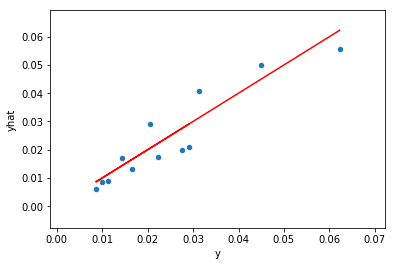

In [18]:
errors_gdl.plot.scatter('y', 'yhat')
plt.plot(errors_gdl.y, errors_gdl.y, color='red')

count    12.000000
mean      0.229657
std       0.088689
min       0.107703
25%       0.179211
50%       0.222874
75%       0.282673
max       0.412898
Name: RAE, dtype: float64

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


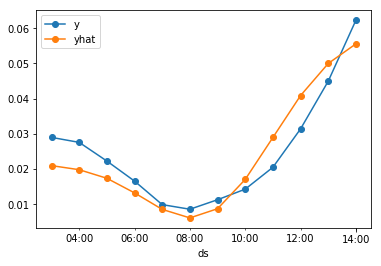

In [19]:
display(errors_gdl.RAE.describe())
errors_gdl.plot(x='ds', y=['y', 'yhat'], style='-o')

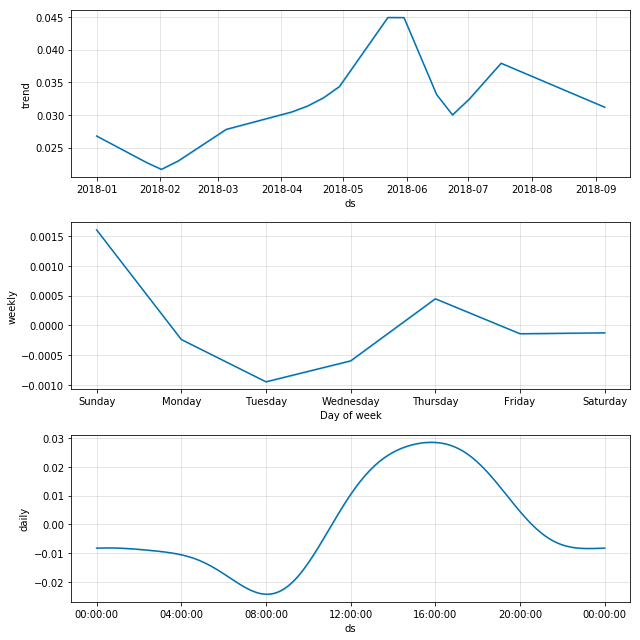

In [20]:
fig = model_gdl.plot_components(fcst_gdl)

# Comparar componentes temporales

Text(0,0.5,'Hora')

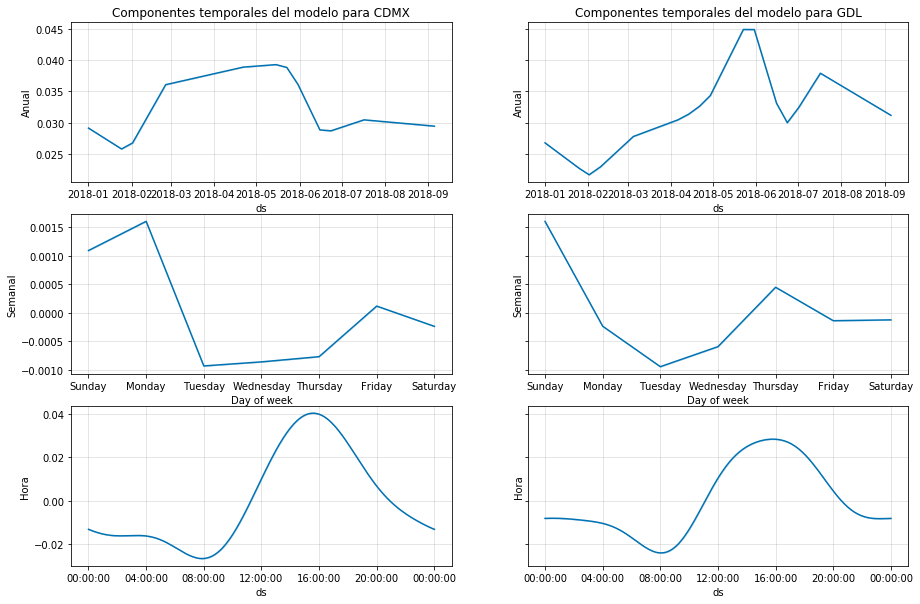

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharey='row')
aux_ax = ax.flatten()

ax[0][0].set_title('Componentes temporales del modelo para CDMX')
ax[0][1].set_title('Componentes temporales del modelo para GDL')

model_cdmx.plot_forecast_component(fcst_cdmx, name='trend', ax=aux_ax[0])
model_gdl.plot_forecast_component(fcst_gdl, name='trend', ax=aux_ax[1])
aux_ax[0].set_ylabel('Anual')
aux_ax[1].set_ylabel('Anual')

model_cdmx.plot_weekly(ax=aux_ax[2])
model_gdl.plot_weekly(ax=aux_ax[3])
aux_ax[2].set_ylabel('Semanal')
aux_ax[3].set_ylabel('Semanal')

model_cdmx.plot_seasonality(name='daily', ax=aux_ax[4])
model_gdl.plot_seasonality(name='daily', ax=aux_ax[5])
aux_ax[4].set_ylabel('Hora')
aux_ax[5].set_ylabel('Hora')

In [24]:
labels

['y', 'yhat']

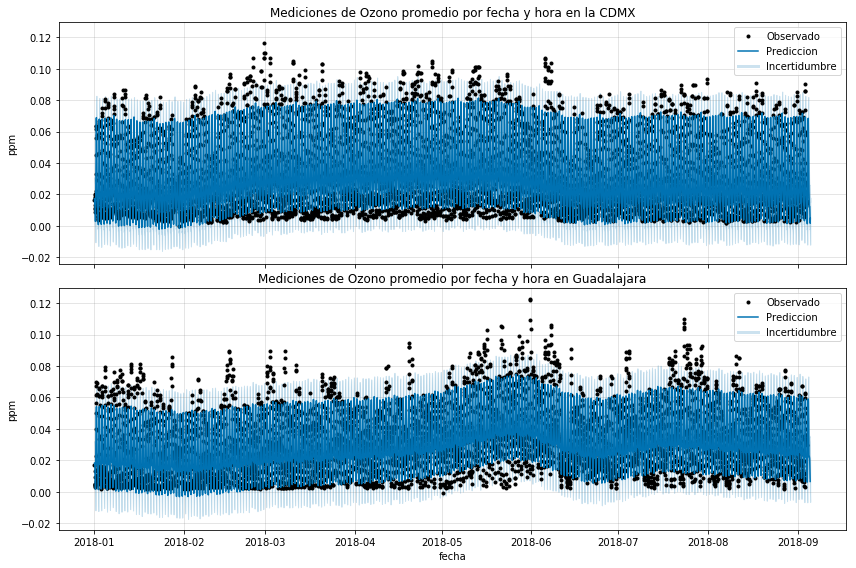

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

a = model_cdmx.plot(fcst_cdmx, ax=ax[0])
ax[0].set_title('Mediciones de Ozono promedio por fecha y hora en la CDMX')
handles, labels = ax[0].get_legend_handles_labels()

uncertainty_patch = mlines.Line2D([], [], color='#0072B2', alpha=0.2, linewidth=3)
handles.append(uncertainty_patch)

ax[0].legend(handles, ['Observado', 'Prediccion', 'Incertidumbre'])
ax[0].set_ylabel('ppm')
ax[0].set_xlabel('')

b = model_gdl.plot(fcst_gdl, ax=ax[1])
ax[1].set_title('Mediciones de Ozono promedio por fecha y hora en Guadalajara')
handles, labels = ax[1].get_legend_handles_labels()
uncertainty_patch = mlines.Line2D([], [], color='#0072B2', alpha=0.2, linewidth=3)
handles.append(uncertainty_patch)

ax[1].legend(handles, ['Observado', 'Prediccion', 'Incertidumbre'])
ax[1].set_ylabel('ppm')
ax[1].set_xlabel('fecha')

plt.subplots_adjust(hspace=0.1)

# Errores

count    12.000000
mean      0.229657
std       0.088689
min       0.107703
25%       0.179211
50%       0.222874
75%       0.282673
max       0.412898
Name: RAE, dtype: float64

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


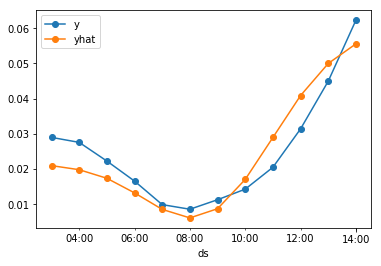

In [25]:
display(errors_gdl.RAE.describe())
errors_gdl.plot(x='ds', y=['y', 'yhat'], style='-o')

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


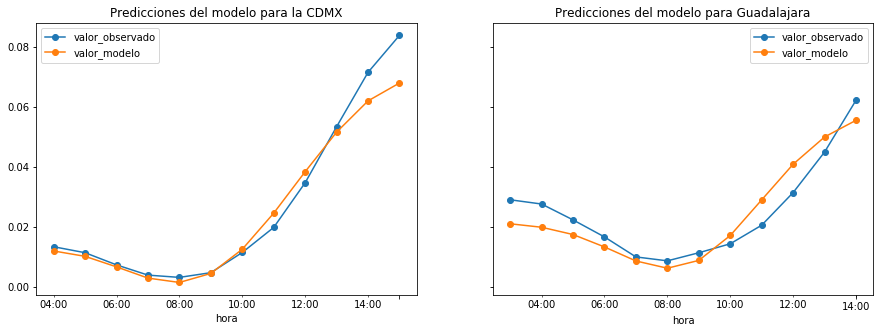

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
aux_ax = ax.flatten()

aux_errors = errors_cdmx.rename(columns={'ds':'hora', 'y':'valor_observado', 'yhat':'valor_modelo'})
aux_errors.plot(x='hora', y=['valor_observado', 'valor_modelo'], style='-o', ax=aux_ax[0],
                title='Predicciones del modelo para la CDMX')

aux_errors = errors_gdl.rename(columns={'ds':'hora', 'y':'valor_observado', 'yhat':'valor_modelo'})
aux_errors.plot(x='hora', y=['valor_observado', 'valor_modelo'], style='-o', ax=aux_ax[1],
                title='Predicciones del modelo para Guadalajara')